# Setup

In [ ]:
import pickle
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

## paths

In [12]:
MODEL_SAVE_PATH = '/content/drive/MyDrive/SYDE 577/BirdClef Models/models/gru_model.h5'
ENCODER_SAVE_PATH = '/content/drive/MyDrive/SYDE 577/BirdClef Models/models/label_encoder.pkl'
RESULTS_DIR = '/content/drive/MyDrive/SYDE 577/BirdClef Models/results/'

PICKLE_PATH = '/content/drive/MyDrive/SYDE 577/BirdClef Models/data/combined_features_logmel_rms_timeseries_mels_64.pkl'

# Training configuration
RANDOM_STATE = 42
TEST_SIZE = 0.15
VALIDATION_SIZE = 0.15
EPOCHS = 100
BATCH_SIZE = 32


## mount to drive

In [13]:
from google.colab import drive
drive.mount('/content/drive')

# Create results directory if it doesn't exist
from pathlib import Path
Path(RESULTS_DIR).mkdir(parents=True, exist_ok=True)
Path(MODEL_SAVE_PATH).parent.mkdir(parents=True, exist_ok=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## pickle files

In [14]:
with open(PICKLE_PATH, 'rb') as f:
        data = pickle.load(f)

# Extract data
X_data = data['X']      # Shape: (samples, features, time_frames)
y_labels = data['y']    # Shape: (samples,)

print(f"   X shape: {X_data.shape}")
print(f"   y shape: {y_labels.shape}")
print(f"   Feature type: {data['feature_type']}")
print(f"   Number of mel bands: {data.get('n_mels', 'N/A')}")
print(f"   Sample rate: {data.get('sample_rate', 'N/A')} Hz")
print(f"   Format: (samples, {X_data.shape[1]} features, {X_data.shape[2]} time_frames)")

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_labels)
num_species = len(label_encoder.classes_)

print(f"   Number of bird species: {num_species}")
print(f"   Species: {list(label_encoder.classes_)}")

X_transposed = np.transpose(X_data, (0, 2, 1))

   X shape: (5077, 65, 938)
   y shape: (5077,)
   Feature type: logmel_rms_timeseries
   Number of mel bands: 64
   Sample rate: 32000 Hz
   Format: (samples, 65 features, 938 time_frames)
   Number of bird species: 10
   Species: ['barswa', 'cohmar1', 'combuz1', 'comsan', 'eaywag1', 'eubeat1', 'hoopoe', 'thrnig1', 'wlwwar', 'woosan']


# Prep data for model

In [ ]:
#normalize data
mean = np.mean(X_transposed)
std = np.std(X_transposed)
X_normalized = (X_transposed - mean) / std

print(f"   Original - Mean: {mean:.4f}, Std: {std:.4f}")
print(f"   Normalized - Mean: {np.mean(X_normalized):.6f}, Std: {np.std(X_normalized):.6f}")

   Original - Mean: -35.7002, Std: 23.5876
   Normalized - Mean: -0.000001, Std: 0.999997


## train/test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized,
    y_encoded,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y_encoded
)

# Test split - separate test set
X_temp, X_test, y_temp, y_test = train_test_split(
    X_normalized,
    y_encoded,
    test_size=0.15,
    random_state=RANDOM_STATE,
    stratify=y_encoded)

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.176,
    random_state=42,
    stratify=y_temp)

print(f"   Training samples: {len(X_train)} ({len(X_train)/len(X_normalized)*100:.1f}%)")
print(f"   Validation samples: {len(X_val)} ({len(X_val)/len(X_normalized)*100:.1f}%)")
print(f"   Testing samples: {len(X_test)} ({len(X_test)/len(X_normalized)*100:.1f}%)")

#class distribution
print(f"\n Class Distribution:")
for species in label_encoder.classes_:
    species_idx = label_encoder.transform([species])[0]
    train_count = np.sum(y_train == species_idx)
    validation_count = np.sum(y_val == species_idx)
    test_count = np.sum(y_test == species_idx)
    print(f"   {species}: {train_count} train, {validation_count} validation, {test_count} test")

   Training samples: 3555 (70.0%)
   Validation samples: 760 (15.0%)
   Testing samples: 762 (15.0%)

 Class Distribution:
   barswa: 371 train, 79 validation, 80 test
   cohmar1: 318 train, 68 validation, 68 test
   combuz1: 355 train, 76 validation, 76 test
   comsan: 372 train, 79 validation, 80 test
   eaywag1: 373 train, 80 validation, 80 test
   eubeat1: 327 train, 70 validation, 70 test
   hoopoe: 329 train, 70 validation, 70 test
   thrnig1: 373 train, 80 validation, 80 test
   wlwwar: 374 train, 80 validation, 80 test
   woosan: 363 train, 78 validation, 78 test


# GRU RNN Model

In [ ]:

model = keras.Sequential([
    # First GRU layer - learns temporal patterns
    layers.GRU(256, return_sequences=True,
               input_shape=(X_train.shape[1], X_train.shape[2]),
               name='gru_1'),
    layers.Dropout(0.4),
    layers.BatchNormalization(),

    # Second GRU layer
    layers.GRU(128, return_sequences=True, name='gru_2'),
    layers.Dropout(0.4),
    layers.BatchNormalization(),

    # Third GRU layer
    layers.GRU(64, name='gru_3'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),

    # Dense layers for classification
    layers.Dense(128, activation='relu', name='dense_1'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu', name='dense_2'),
    layers.Dropout(0.2),

    # Output layer
    layers.Dense(num_species, activation='softmax', name='output')
], name='BirdCLEF_GRU')

# Compile
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

# Count parameters
total_params = model.count_params()
print(f"   Total parameters: {total_params:,}")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "BirdCLEF_GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 938, 256)       │       248,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 938, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 938, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 938, 128)       │       148,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 938, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 938, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 452,554 (1.73 MB)

 Trainable params: 451,658 (1.72 MB)

 Non-trainable params: 896 (3.50 KB)

None
   Total parameters: 452,554


## training

In [ ]:
# Callbacks
callbacks = [
    # Stop if not improving
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=20,
        restore_best_weights=True,
        verbose=1
    ),

    # Reduce learning rate when stuck
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-7,
        verbose=1
    ),

    # Save best model
    keras.callbacks.ModelCheckpoint(
        MODEL_SAVE_PATH,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]


history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.1250 - loss: 2.4095
Epoch 1: val_accuracy improved from -inf to 0.18684, saving model to /content/drive/MyDrive/SYDE 577/BirdClef Models/models/gru_model.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 22s 126ms/step - accuracy: 0.1252 - loss: 2.4089 - val_accuracy: 0.1868 - val_loss: 2.2136 - learning_rate: 0.0010
Epoch 2/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.1720 - loss: 2.2559
Epoch 2: val_accuracy improved from 0.18684 to 0.18947, saving model to /content/drive/MyDrive/SYDE 577/BirdClef Models/models/gru_model.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - accuracy: 0.1720 - loss: 2.2557 - val_accuracy: 0.1895 - val_loss: 2.1705 - learning_rate: 0.0010
Epoch 3/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.1835 - loss: 2.2048
Epoch 3: val_accuracy improved from 0.18947 to 0.21316, saving model to /content/drive/MyDrive/SYDE 577/BirdClef Models/models/gru_model.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.1836 - loss: 2.2047 - val_accuracy: 0.2132 - val_loss: 2.1393 - learning_rate: 0.0010
Epoch 4/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.2366 - loss: 2.0989
Epoch 4: val_accuracy improved from 0.21316 to 0.23816, saving model to /content/drive/MyDrive/SYDE 577/BirdClef Models/models/gru_model.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.2366 - loss: 2.0987 - val_accuracy: 0.2382 - val_loss: 2.0715 - learning_rate: 0.0010
Epoch 5/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.2631 - loss: 2.0203
Epoch 5: val_accuracy improved from 0.23816 to 0.31842, saving model to /content/drive/MyDrive/SYDE 577/BirdClef Models/models/gru_model.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 0.2631 - loss: 2.0201 - val_accuracy: 0.3184 - val_loss: 1.9327 - learning_rate: 0.0010
Epoch 6/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.2893 - loss: 1.9400
Epoch 6: val_accuracy improved from 0.31842 to 0.33289, saving model to /content/drive/MyDrive/SYDE 577/BirdClef Models/models/gru_model.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.2894 - loss: 1.9399 - val_accuracy: 0.3329 - val_loss: 1.8827 - learning_rate: 0.0010
Epoch 7/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.3331 - loss: 1.8801
Epoch 7: val_accuracy improved from 0.33289 to 0.41711, saving model to /content/drive/MyDrive/SYDE 577/BirdClef Models/models/gru_model.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 15s 131ms/step - accuracy: 0.3332 - loss: 1.8798 - val_accuracy: 0.4171 - val_loss: 1.7845 - learning_rate: 0.0010
Epoch 8/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.3730 - loss: 1.7751
Epoch 8: val_accuracy did not improve from 0.41711
112/112 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - accuracy: 0.3732 - loss: 1.7747 - val_accuracy: 0.3842 - val_loss: 1.7588 - learning_rate: 0.0010
Epoch 9/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.4329 - loss: 1.6317
Epoch 9: val_accuracy improved from 0.41711 to 0.46711, saving model to /content/drive/MyDrive/SYDE 577/BirdClef Models/models/gru_model.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.4331 - loss: 1.6313 - val_accuracy: 0.4671 - val_loss: 1.5727 - learning_rate: 0.0010
Epoch 10/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.4763 - loss: 1.5250
Epoch 10: val_accuracy improved from 0.46711 to 0.47763, saving model to /content/drive/MyDrive/SYDE 577/BirdClef Models/models/gru_model.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 15s 131ms/step - accuracy: 0.4765 - loss: 1.5247 - val_accuracy: 0.4776 - val_loss: 1.4923 - learning_rate: 0.0010
Epoch 11/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.5135 - loss: 1.4314
Epoch 11: val_accuracy improved from 0.47763 to 0.50395, saving model to /content/drive/MyDrive/SYDE 577/BirdClef Models/models/gru_model.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 15s 131ms/step - accuracy: 0.5137 - loss: 1.4310 - val_accuracy: 0.5039 - val_loss: 1.6475 - learning_rate: 0.0010
Epoch 12/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.5707 - loss: 1.2892
Epoch 12: val_accuracy improved from 0.50395 to 0.56184, saving model to /content/drive/MyDrive/SYDE 577/BirdClef Models/models/gru_model.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 15s 131ms/step - accuracy: 0.5707 - loss: 1.2892 - val_accuracy: 0.5618 - val_loss: 1.3562 - learning_rate: 0.0010
Epoch 13/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.6157 - loss: 1.2200
Epoch 13: val_accuracy improved from 0.56184 to 0.58289, saving model to /content/drive/MyDrive/SYDE 577/BirdClef Models/models/gru_model.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 15s 131ms/step - accuracy: 0.6157 - loss: 1.2197 - val_accuracy: 0.5829 - val_loss: 1.2659 - learning_rate: 0.0010
Epoch 14/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.6059 - loss: 1.2306
Epoch 14: val_accuracy did not improve from 0.58289
112/112 ━━━━━━━━━━━━━━━━━━━━ 14s 121ms/step - accuracy: 0.6054 - loss: 1.2322 - val_accuracy: 0.3408 - val_loss: 2.0371 - learning_rate: 0.0010
Epoch 15/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.4662 - loss: 1.5741
Epoch 15: val_accuracy did not improve from 0.58289
112/112 ━━━━━━━━━━━━━━━━━━━━ 14s 121ms/step - accuracy: 0.4667 - loss: 1.5730 - val_accuracy: 0.5408 - val_loss: 1.4553 - learning_rate: 0.0010
Epoch 16/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.6039 - loss: 1.2588
Epoch 16: val_accuracy improved from 0.58289 to 0.64474, saving model to /content/drive/MyDrive/SYDE 577/BirdClef Models/models/gru_model.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 15s 131ms/step - accuracy: 0.6041 - loss: 1.2583 - val_accuracy: 0.6447 - val_loss: 1.2157 - learning_rate: 0.0010
Epoch 17/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.6692 - loss: 1.0859
Epoch 17: val_accuracy did not improve from 0.64474
112/112 ━━━━━━━━━━━━━━━━━━━━ 14s 122ms/step - accuracy: 0.6693 - loss: 1.0856 - val_accuracy: 0.6408 - val_loss: 1.1740 - learning_rate: 0.0010
Epoch 18/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.7238 - loss: 0.9592
Epoch 18: val_accuracy did not improve from 0.64474
112/112 ━━━━━━━━━━━━━━━━━━━━ 14s 121ms/step - accuracy: 0.7237 - loss: 0.9593 - val_accuracy: 0.6237 - val_loss: 1.2034 - learning_rate: 0.0010
Epoch 19/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.5314 - loss: 1.4564
Epoch 19: val_accuracy did not improve from 0.64474
112/112 ━━━━━━━━━━━━━━━━━━━━ 14s 121ms/step - accuracy: 0.5307 - loss: 1.4582 - val_accuracy: 0.4447 - val_loss: 1.6898 - learning_rate: 0.001

# Evaluate on Test set

   Test Loss: 1.1055
   Test Accuracy: 0.6654 (66.54%)
              precision    recall  f1-score   support

      barswa      0.529     0.338     0.412        80
     cohmar1      0.461     0.691     0.553        68
     combuz1      0.716     0.763     0.739        76
      comsan      0.577     0.750     0.652        80
     eaywag1      0.522     0.738     0.611        80
     eubeat1      0.762     0.914     0.831        70
      hoopoe      0.800     0.629     0.704        70
     thrnig1      0.887     0.688     0.775        80
      wlwwar      0.812     0.700     0.752        80
      woosan      0.902     0.474     0.622        78

    accuracy                          0.665       762
   macro avg      0.697     0.668     0.665       762
weighted avg      0.698     0.665     0.664       762



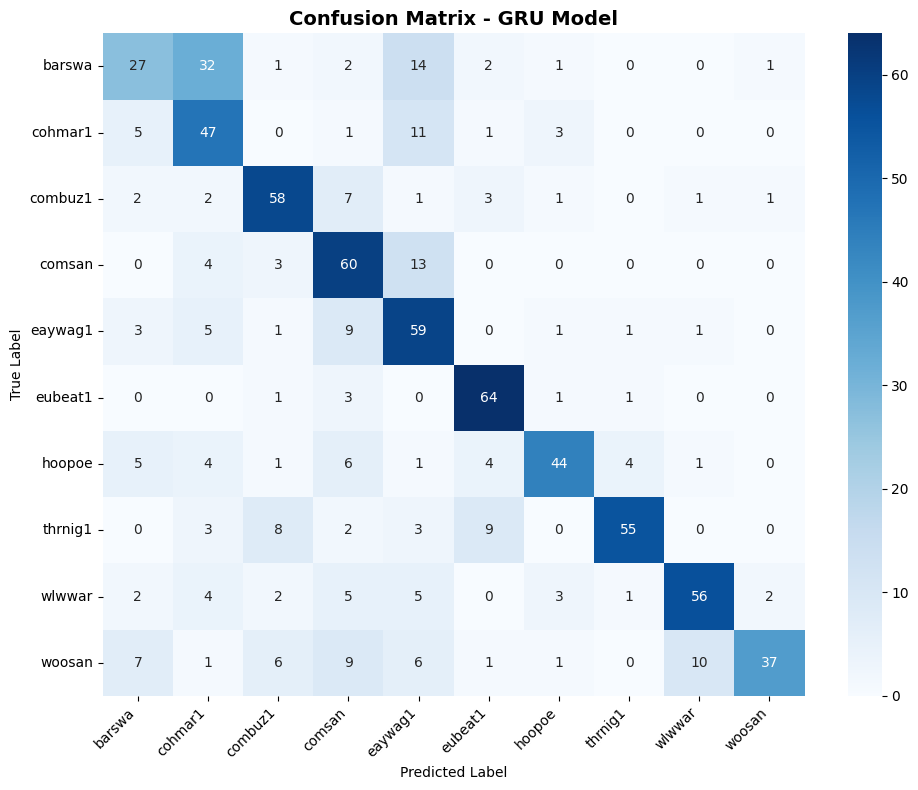

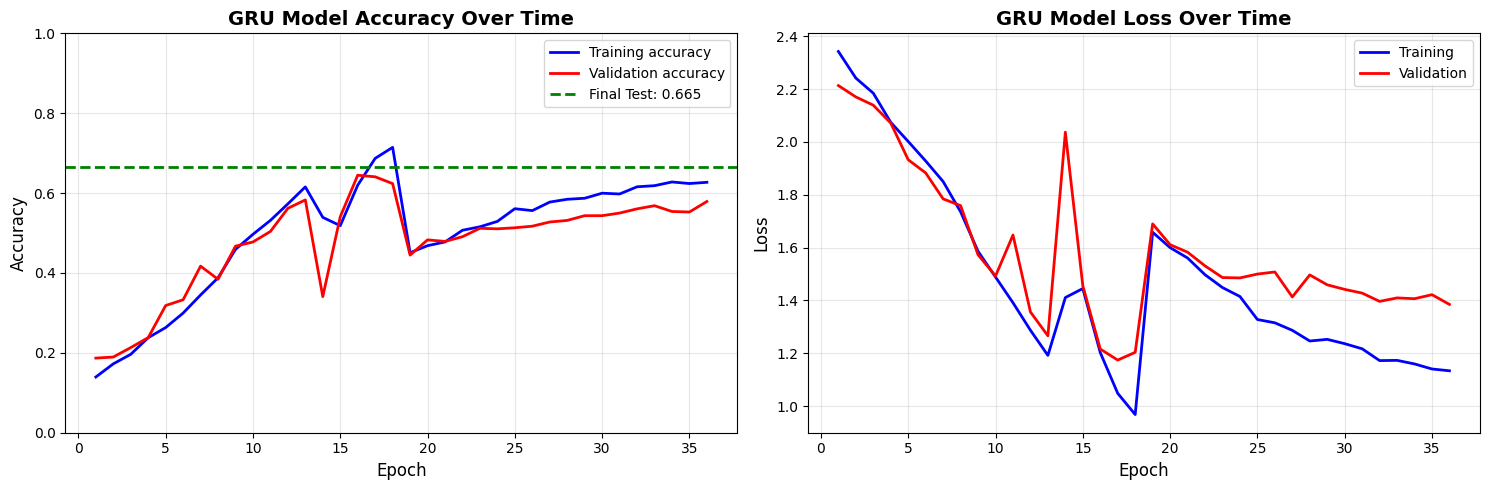

In [ ]:

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"   Test Loss: {test_loss:.4f}")
print(f"   Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Get predictions
y_pred_probs = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(
    y_test, y_pred,
    target_names=label_encoder.classes_,
    digits=3
))

#confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - GRU Model', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

#training history plot

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

epochs_range = range(1, len(history.history['accuracy']) + 1)

# Accuracy plot
ax1.plot(epochs_range, history.history['accuracy'], 'b-', label='Training accuracy', linewidth=2)
ax1.plot(epochs_range, history.history['val_accuracy'], 'r-', label='Validation accuracy', linewidth=2)
ax1.axhline(y=test_accuracy, color='g', linestyle='--', label=f'Final Test: {test_accuracy:.3f}', linewidth=2)
ax1.set_title('GRU Model Accuracy Over Time', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1])

# Loss plot
ax2.plot(epochs_range, history.history['loss'], 'b-', label='Training', linewidth=2)
ax2.plot(epochs_range, history.history['val_loss'], 'r-', label='Validation', linewidth=2)
ax2.set_title('GRU Model Loss Over Time', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}training_history.png', dpi=150, bbox_inches='tight')
plt.show()



## save files

In [ ]:


# Model already saved by ModelCheckpoint
print(f"Model saved to: {MODEL_SAVE_PATH}")

# Save label encoder
joblib.dump(label_encoder, ENCODER_SAVE_PATH)
print(f" Label encoder saved to: {ENCODER_SAVE_PATH}")

# Save results summary
results_summary = {
    'test_accuracy': float(test_accuracy),
    'test_loss': float(test_loss),
    'epochs_trained': len(history.history['accuracy']),
    'best_val_accuracy': float(max(history.history['val_accuracy'])),
    'num_species': num_species,
    'species': list(label_encoder.classes_),
    'total_samples': len(X_data),
    'train_samples': len(X_train),
    'test_samples': len(X_test),
}

import json
with open(f'{RESULTS_DIR}results_summary.json', 'w') as f:
    json.dump(results_summary, f, indent=2)
print(f"✅ Results summary saved to: {RESULTS_DIR}results_summary.json")


print(f"   Test Accuracy: {test_accuracy*100:.2f}%")
print(f"   Test Loss: {test_loss:.4f}")
print(f"   Epochs trained: {len(history.history['accuracy'])}")
print(f"   Best validation accuracy: {max(history.history['val_accuracy'])*100:.2f}%")
print(f"   Training samples: {len(X_train)}")
print(f"   Test samples: {len(X_test)}")

print(f"\n Saved Files:")
print(f"   • Model: {MODEL_SAVE_PATH}")
print(f"   • Label Encoder: {ENCODER_SAVE_PATH}")
print(f"   • Confusion Matrix: {RESULTS_DIR}confusion_matrix.png")
print(f"   • Training History: {RESULTS_DIR}training_history.png")
print(f"   • Results Summary: {RESULTS_DIR}results_summary.json")


Model saved to: /content/drive/MyDrive/SYDE 577/BirdClef Models/models/gru_model.h5
 Label encoder saved to: /content/drive/MyDrive/SYDE 577/BirdClef Models/models/label_encoder.pkl
✅ Results summary saved to: /content/drive/MyDrive/SYDE 577/BirdClef Models/results/results_summary.json
   Test Accuracy: 66.54%
   Test Loss: 1.1055
   Epochs trained: 36
   Best validation accuracy: 64.47%
   Training samples: 3555
   Test samples: 762

 Saved Files:
   • Model: /content/drive/MyDrive/SYDE 577/BirdClef Models/models/gru_model.h5
   • Label Encoder: /content/drive/MyDrive/SYDE 577/BirdClef Models/models/label_encoder.pkl
   • Confusion Matrix: /content/drive/MyDrive/SYDE 577/BirdClef Models/results/confusion_matrix.png
   • Training History: /content/drive/MyDrive/SYDE 577/BirdClef Models/results/training_history.png
   • Results Summary: /content/drive/MyDrive/SYDE 577/BirdClef Models/results/results_summary.json
